# Object (Vehicle) Detection using deep learning (YOLO)

In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

Using TensorFlow backend.


## 1 - Business Problem Statement
1.The data is collected using the camera mounted on the traffic light that takes pictures of the road along with the vehicles and hence the video is taken and recorded and it has been uploaded in the another section of the submission i.e. a video of the moving vehicles on the road.

2.The video was converted into image frames which were labelled using the drawing of the bounding boxes around every vehicle that is found on the road. 

3.The different classes have been mentioned in the YOLO and these are labelled as an integer from 1 to 80 and these classes can be increased also by increase in the dataset.

4.As YOLO is computationally very expensive to train, hence the team has used pre-trained weights to use on the dataset.

#### YOLO (you look only once)
 It achieves higher accuracy in the real-time. it "only looks once" at image followed by the only one forward propagation pass through the network to make valuable predictions. Then it uses non-max suppression and outputs the recognized objects. here vehicles with the bounding boxes. 









###  Model architecture

1. The **input** is a batch of images of shape (m, 608, 608, 3)
2. The **output** is a list of bounding boxes along with the recognized classes. 
3. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above.
4. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

We have used  5 anchor boxes of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.The last two dimensions of the shape (19, 19, 5, 85) encoding have been flattened giving the output of Deep CNN is (19, 19, 425).

######  YOLO architecture :
IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).





### Filtering with a threshold on class scores

You are going to apply a first filter by thresholding. You would like to get rid of any box for which the class "score" is less than a chosen threshold. 

The model gives you a total of 19x19x5x85 numbers, with each box described by 85 numbers. It'll be convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19 \times 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19 \times 19, 5, 4)$ containing $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes per cell.
- `box_class_probs`: tensor of shape $(19 \times 19, 5, 80)$ containing the detection probabilities $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.



In [2]:


def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    
    box_scores = box_confidence * box_class_probs
    
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    
    box_classes = K.argmax(box_scores, axis = -1)
    box_class_scores = K.max(box_scores, axis = -1)
    
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    
    filtering_mask = box_class_scores >= threshold
    
    
    # Step 4: Apply the mask to scores, boxes and classes
   
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    
    return scores, boxes, classes

In [3]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


###  Non-max suppression ###

1.Even after filtering by thresholding over the classes scores, to remove the  overlapping boxes, A second filter for selecting the right boxes called non-maximum suppression (NMS) is used.

2.It uses "Intersection over Union" or IOU that uses its two corners (upper left and lower right): `(x1, y1, x2, y2)` rather than the midpoint and height/width to create a box.

3.For the area of a rectangle  multiply its height `(y2 - y1)` by its width `(x2 - x1)`.

4.Find the coordinates `(xi1, yi1, xi2, yi2)` of the intersection of two boxes:
  - xi1 = maximum of the x1 coordinates of the two boxes
    - yi1 = maximum of the y1 coordinates of the two boxes
    - xi2 = minimum of the x2 coordinates of the two boxes
    - yi2 = minimum of the y2 coordinates of the two boxes
    
5.The height and width of the intersection are positive, otherwise the intersection area should be zero. Use `max(height, 0)` and `max(width, 0)`. (0,0) is the top-left corner of an image, (1,0) is the upper-right corner, and (1,1) the lower-right corner.   

Implement non-max suppression: 
1. Select the box that has the highest score.
2. Compute its overlap with all other boxes, and remove boxes that overlap it more than `iou_threshold`.
3. Go back to step 1 and iterate until there's no more boxes with a lower score than the current selected box.

It removes all boxes with a  large overlap with the selected boxes. Only the "best" boxes remain.



In [4]:

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
  
    nms_indices = tf.image.non_max_suppression(boxes = boxes, scores = scores, max_output_size = max_boxes, iou_threshold = iou_threshold)
    
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
   
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    
    return scores, boxes, classes

In [5]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))





scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


### Evaluation of the filtering

`yolo_eval()` takes the output of the deep CNN (the 19x19x5x85 dimensional YOLO  encoding) and filtering through all the boxes using the score threshold and NMS. YOLO converts between a few such formats at different times. 

```python
boxes = yolo_boxes_to_corners(box_xy, box_wh) 
```
which converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2) to fit the input of `yolo_filter_boxes`
```python
boxes = scale_boxes(boxes, image_shape)
```


In [6]:

def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    
    
    # Retrieve outputs of the YOLO model 
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
  
    
    return scores, boxes, classes

In [7]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


<font color='red'>
**Summary for architecture of vehicle detection **:
    
- Input image is of the size (608, 608, 3)

- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output.

- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and and 80 is the number of classes we'd like to detect
    
- Select best boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output of vehicle detection on the road in the image frames created using the video taken by a camera placed on the traffic light. 

##  Test YOLO on our dataset

In [8]:
#create a session
sess = K.get_session()

###### We have defined the classes, anchors and the shape of the images  using the 80 classes, and are using 5 anchor boxes in two files "coco_classes.txt" and "yolo_anchors.txt". This dataset consists of the  720x1280 images that are processed into the 608x608 images. 

In [9]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

###### We loaded a pretrained model of YOLO in "yolo.h5".



In [35]:
!ls

0114.jpg
Autonomous-driving-application-Car-detection-v3.ipynb
data.txt
font
images
lost+found
model_data
objects-final.csv
out
__pycache__
Team_UIET_Bughunters_executed_test_cases.docx
test.jpg
total_number_of_vehicles.csv
Untitled1.ipynb
Untitled.ipynb
yad2k
yolo_utils.py


In [10]:
yolo_model = load_model("model_data/yolo.h5")

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
#This loads the weights of a trained YOLO model. Summary of the layers of the model.
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

### Convert output of the model to usable bounding box tensors

The output of `yolo_model` is a (m, 19, 19, 5, 85) tensor that needs to pass through non-trivial processing and conversion. 

In [12]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

Add `yolo_outputs` to the graph. This set of 4 tensors is ready to be used as input by the `yolo_eval` function.

###  Filtering boxes

`yolo_outputs` gave  all the predicted boxes of `yolo_model` in the correct format. Call `yolo_eval`now.

In [13]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

### Test on the image


1. <font color='purple'> yolo_model.input </font> is given to `yolo_model`. The model is used to compute the output <font color='purple'> yolo_model.output </font>
2. <font color='purple'> yolo_model.output </font> is processed by `yolo_head`. It gives you <font color='purple'> yolo_outputs </font>
3. <font color='purple'> yolo_outputs </font> goes through a filtering function, `yolo_eval`. It outputs your predictions: <font color='purple'> scores, boxes, classes </font>



In [14]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
    ### END CODE HERE ###

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    import pandas
    df = pd.DataFrame()
    df['objects'] = [len(out_boxes)]
    df.to_csv("total_number_of_vehicles.csv", mode='a', header=False,index=False)
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    
    image.save(os.path.join("out", image_file), quality=90)
    import imageio
    im = imageio.imread(os.path.join("out",image_file))
    # Display the results in the notebook
    #output_image = scipy.misc.imread(os.path.join(image_file))
    imshow(im)
    
    
    # Display the results in the notebook
    #output_image = scipy.misc.imread(os.path.join("out", image_file))
    #imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Found 7 boxes for test.jpg
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


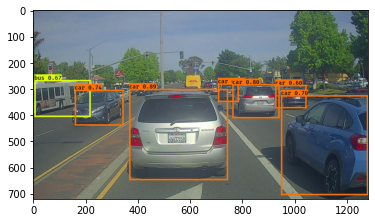

In [20]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")
a=len(out_boxes)


Found 2 boxes for 1060.jpg
car 0.71 (92, 365) (378, 417)
car 0.75 (570, 335) (976, 402)


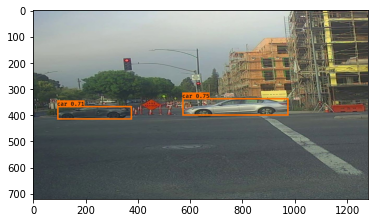

In [21]:
out_scores, out_boxes, out_classes = predict(sess, "1060.jpg")
b=len(out_boxes)

##### Store the results in a csv and text file to be fectched in the processing model for interface of the traffic light system.

In [31]:
with open('total_number_of_vehicles.csv', 'r') as inp, open('data.txt', 'w') as out:
    line2 = ""
    for line in inp:
        line = line.replace('\n', ',')
        line2 += line
    line2 = ','.join(line2.split(',', 2)[:2])
    out.write(line2)
#with open('total_number_of_vehicles.csv', 'r') as inp, open('data.txt', 'w') as out:
#    for line in inp:
#        line = line.replace('\n', ',')
#        out.write(line)


### Store the file "data.txt" in Amazon S3 storage bucket so that it can be fetched using the time scheduling algorithm

In [32]:
import os
import urllib.request
import boto3


In [33]:
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket('oobj-det0910').put_object(Key=key, Body=data)

In [34]:
s3 = boto3.resource('s3')
for bucket in s3.buckets.all():
    print(bucket.name)

oobj-det0910
test-bucket-175108


In [35]:
data = open('data.txt', 'rb')
s3.Bucket('oobj-det0910').put_object(Key='data.txt', Body=data)

s3.Object(bucket_name='oobj-det0910', key='data.txt')

Found 4 boxes for 0004.jpg
car 0.63 (400, 285) (515, 327)
car 0.66 (95, 297) (227, 342)
car 0.68 (1, 321) (121, 410)
car 0.72 (539, 277) (658, 318)


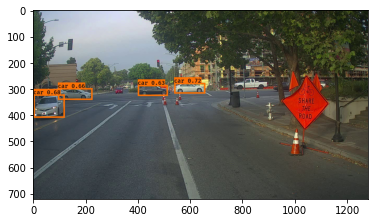

In [36]:
out_scores, out_boxes, out_classes = predict(sess, "0004.jpg")

Found 2 boxes for 0006.jpg
car 0.72 (470, 286) (686, 343)
car 0.72 (72, 320) (220, 367)


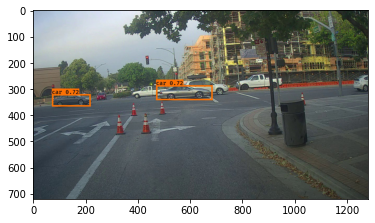

In [30]:
out_scores, out_boxes, out_classes = predict(sess, "0006.jpg")

Found 2 boxes for 0007.jpg
car 0.67 (1086, 243) (1225, 312)
car 0.78 (468, 292) (685, 353)


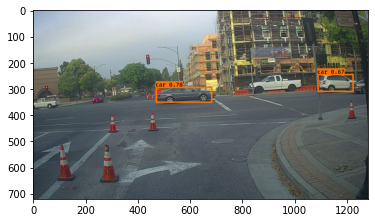

In [50]:
out_scores, out_boxes, out_classes = predict(sess, "0007.jpg")

Found 2 boxes for 0008.jpg
truck 0.63 (852, 252) (1083, 330)
car 0.78 (1082, 275) (1275, 340)


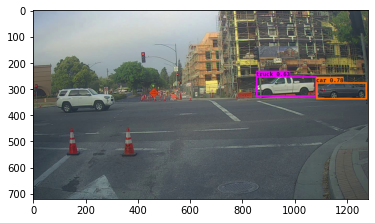

In [51]:
out_scores, out_boxes, out_classes = predict(sess, "0008.jpg")

Found 0 boxes for 0009.jpg


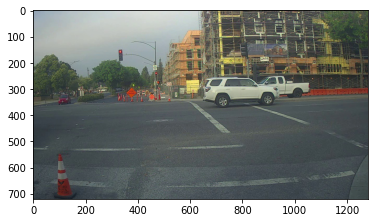

In [52]:
out_scores, out_boxes, out_classes = predict(sess, "0009.jpg")

Found 1 boxes for 0010.jpg
truck 0.66 (736, 266) (1054, 368)


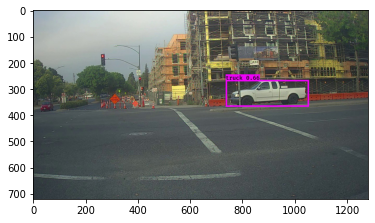

In [53]:
out_scores, out_boxes, out_classes = predict(sess, "0010.jpg")

Found 2 boxes for 0011.jpg
truck 0.73 (727, 269) (1054, 376)
car 0.85 (6, 336) (212, 457)


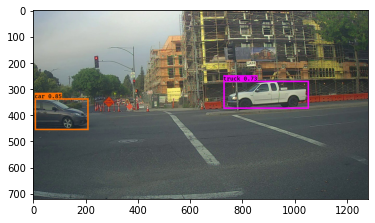

In [54]:
out_scores, out_boxes, out_classes = predict(sess, "0011.jpg")

Found 2 boxes for 0012.jpg
car 0.77 (792, 279) (1163, 408)
car 0.87 (539, 330) (998, 459)


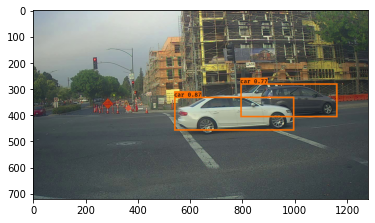

In [55]:
out_scores, out_boxes, out_classes = predict(sess, "0012.jpg")

Found 1 boxes for 0013.jpg
truck 0.65 (718, 276) (1053, 385)


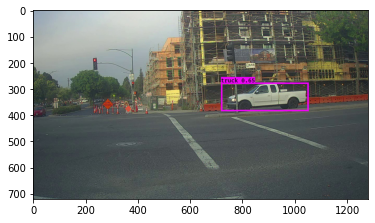

In [56]:
out_scores, out_boxes, out_classes = predict(sess, "0013.jpg")

Found 1 boxes for 0014.jpg
truck 0.64 (715, 274) (1056, 385)


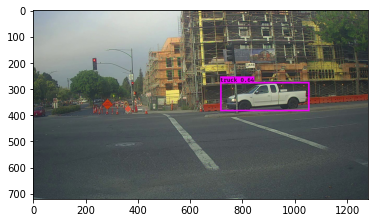

In [57]:
out_scores, out_boxes, out_classes = predict(sess, "0014.jpg")

Found 1 boxes for 0015.jpg
truck 0.72 (713, 275) (1086, 386)


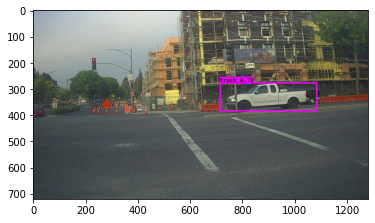

In [58]:
out_scores, out_boxes, out_classes = predict(sess, "0015.jpg")

Found 2 boxes for 0018.jpg
car 0.76 (71, 362) (242, 419)
car 0.77 (340, 339) (553, 401)


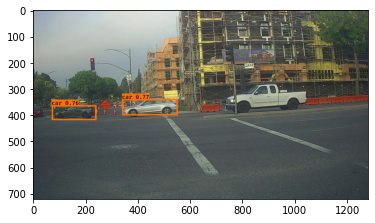

In [59]:
out_scores, out_boxes, out_classes = predict(sess, "0018.jpg")

Found 0 boxes for 0032.jpg


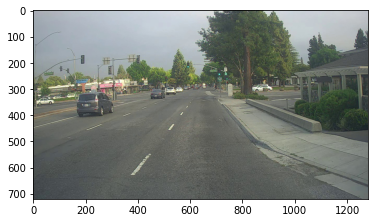

In [60]:
out_scores, out_boxes, out_classes = predict(sess, "0032.jpg")

Found 2 boxes for 0073.jpg
car 0.74 (145, 313) (248, 374)
car 0.85 (503, 299) (858, 421)


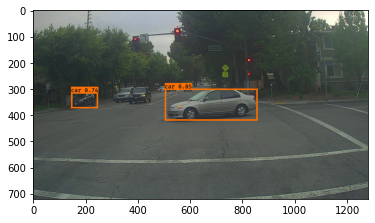

In [61]:
out_scores, out_boxes, out_classes = predict(sess, "0073.jpg")

Found 4 boxes for 0076.jpg
traffic light 0.62 (381, 93) (407, 146)
car 0.66 (246, 298) (336, 366)
car 0.70 (369, 292) (451, 357)
car 0.75 (150, 313) (245, 375)


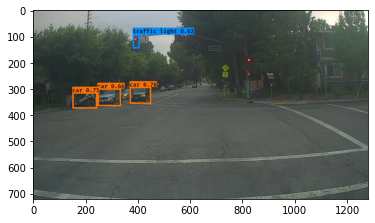

In [62]:
out_scores, out_boxes, out_classes = predict(sess, "0076.jpg")

Found 5 boxes for 0077.jpg
traffic light 0.60 (536, 65) (571, 112)
traffic light 0.60 (380, 92) (407, 147)
car 0.70 (243, 296) (345, 368)
car 0.71 (368, 292) (450, 356)
car 0.75 (150, 313) (245, 374)


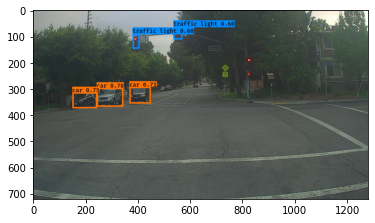

In [63]:
out_scores, out_boxes, out_classes = predict(sess, "0077.jpg")

Found 4 boxes for 0080.jpg
traffic light 0.61 (379, 92) (407, 147)
car 0.64 (5, 309) (188, 416)
car 0.71 (237, 298) (324, 366)
car 0.79 (714, 282) (916, 362)


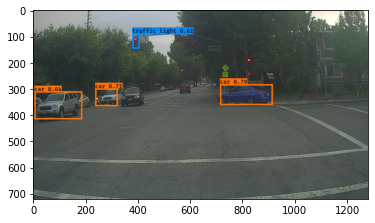

In [64]:
out_scores, out_boxes, out_classes = predict(sess, "0080.jpg")

Found 1 boxes for 0103.jpg
bus 0.74 (0, 286) (203, 420)


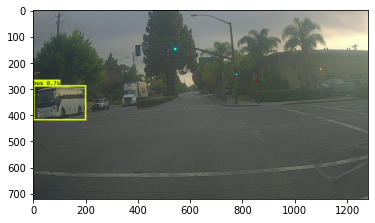

In [65]:
out_scores, out_boxes, out_classes = predict(sess, "0103.jpg")

Found 0 boxes for 0120.jpg


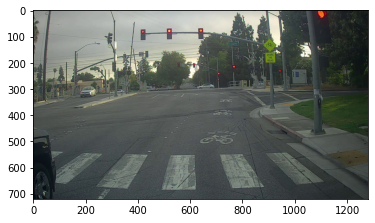

In [66]:
out_scores, out_boxes, out_classes = predict(sess, "0120.jpg")

In [67]:
print("------------------------------end connect to the window instance using cloud services--------------------------------")

------------------------------end connect to the window instance using cloud services--------------------------------


<font color='blue'>
Hence when the model is tested on the image it has clearly given the output of the total number of vehicles in the image that are to be used in the timing algorithm for the smart traffic lights. The total number of the vehicles in the four lanes on the road near the round-about has been calculated effectively and hence this is used in the scheduling of timing in seconds to the different lanes on the road so as to reduce the traffic congestion problem on the roads.